In [2]:
!pip install ultralytics -q


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: pip install --upgrade pip



image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0002.jpg: 864x1504 4 GREYTRAINs, 1 HIGHBARRIER1, 2 ORANGETRAINs, 1 RAMP, 2 Railss, 287.1ms
Speed: 9.3ms preprocess, 287.1ms inference, 20.1ms postprocess per image at shape (1, 3, 864, 1504)
[np.int64(1), np.int64(2), np.int64(6), np.int64(8), np.int64(9)]


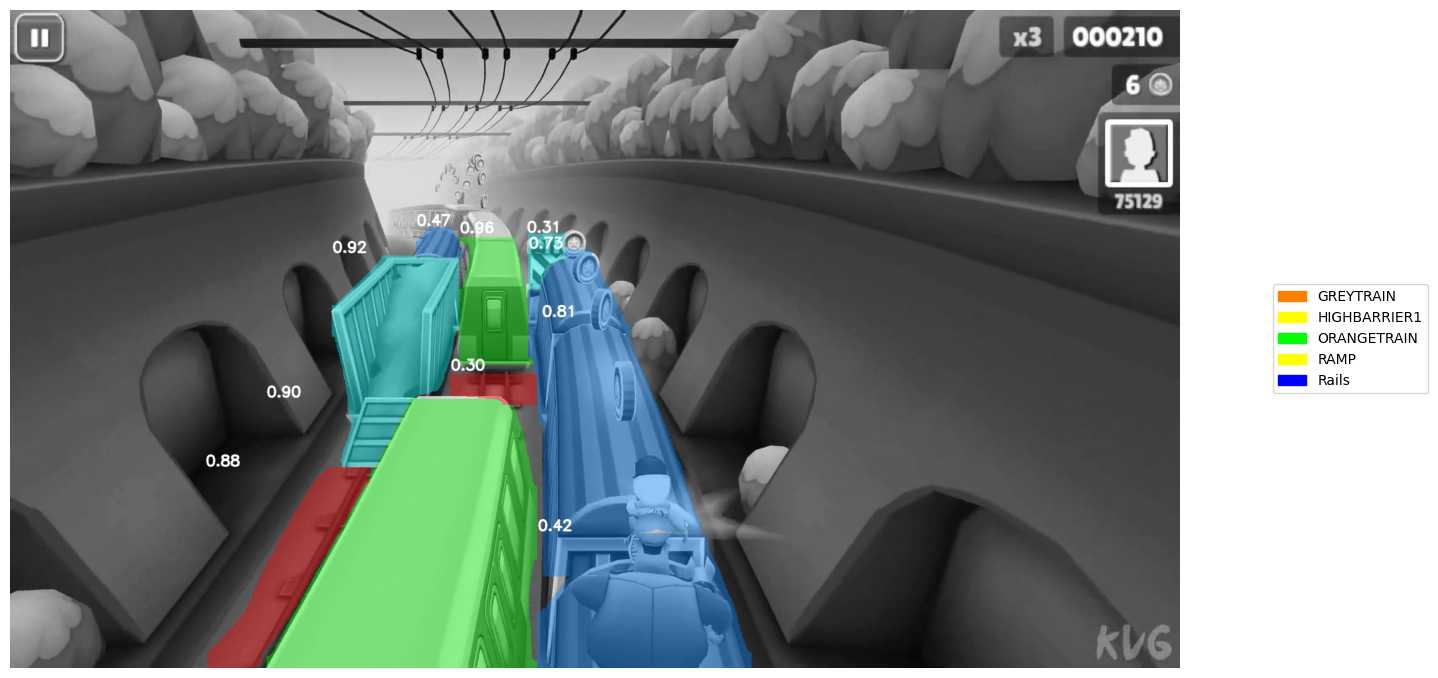

[6 8 6 9 1 1 1 1 2 9]


In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from ultralytics import YOLO

def cycle(j, i):
    # ————————————————————————————————
    # 1) SETUP
    # ————————————————————————————————
    home     = os.path.expanduser("~")
    weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
    img_path = f"{home}/SubwaySurfers/train_screenshots/frame_00{j}{i}.jpg"
    
    # ————————————————————————————————
    # 2) RUN SEGMENTATION
    # ————————————————————————————————
    model   = YOLO(weights)
    results = model.predict(source=img_path, task="segment", conf=0.30, iou=0.45)[0]
    
    polygons    = results.masks.xy
    class_ids   = results.boxes.cls.cpu().numpy().astype(int)
    confidences = results.boxes.conf.cpu().numpy()             # ← extract confidences
    names       = results.names  # dict: id → class name
    
    # ————————————————————————————————
    # 3) MAKE A GRAYSCALE BACKGROUND
    # ————————————————————————————————
    img_color = cv2.imread(img_path)
    img_gray  = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    bg_gray3  = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    
    # ————————————————————————————————
    # 4) ASSIGN COLORS (CUSTOM RGB)
    # ————————————————————————————————
    unique_ids = sorted(set(class_ids))
    print(unique_ids)
    
    custom_colors = {
        1: (255, 128,   0),
        6: (  0, 255,   0),
        9: (  0,   0, 255),
        11: (255, 100, 100),
    }
    color_map = {cid: custom_colors.get(cid, (255, 255, 0)) for cid in unique_ids}
    
    # ————————————————————————————————
    # 5) RENDER THE OVERLAY
    # ————————————————————————————————
    overlay = bg_gray3.copy()
    for poly, cid in zip(polygons, class_ids):
        pts = poly.astype(np.int32).reshape(-1, 1, 2)
        cv2.fillPoly(overlay, [pts], color_map[cid])
    
    alpha   = 0.4
    blended = cv2.addWeighted(overlay, alpha, bg_gray3, 1 - alpha, 0)
    
    # ————————————————————————————————
    #    Draw confidence score above each mask
    # ————————————————————————————————
    boxes = results.boxes.xyxy.cpu().numpy().astype(int)
    for conf, box in zip(confidences, boxes):
        x1, y1, _, _ = box
        label = f"{conf:.2f}"
        cv2.putText(
            blended, label, (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA
        )
    
    # ————————————————————————————————
    # 6) PLOT + LEGEND
    # ————————————————————————————————
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    ax.axis(False)
    
    patches = [
        Patch(color=np.array(color_map[cid]) / 255.0, label=names[cid])
        for cid in unique_ids
    ]
    fig.legend(handles=patches, loc="center right", bbox_to_anchor=(1.2, 0.5))
    plt.tight_layout()
    plt.show()

    print(class_ids)



cycle(0, 2)



image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0200.jpg: 864x1504 1 GREYTRAIN, 1 HIGHBARRIER1, 2 ORANGETRAINs, 3 Railss, 2 YELLOWTRAINs, 309.7ms
Speed: 7.9ms preprocess, 309.7ms inference, 17.8ms postprocess per image at shape (1, 3, 864, 1504)

image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0000.jpg: 864x1504 2 ORANGETRAINs, 1 Rails, 3 YELLOWTRAINs, 254.2ms
Speed: 8.5ms preprocess, 254.2ms inference, 10.4ms postprocess per image at shape (1, 3, 864, 1504)


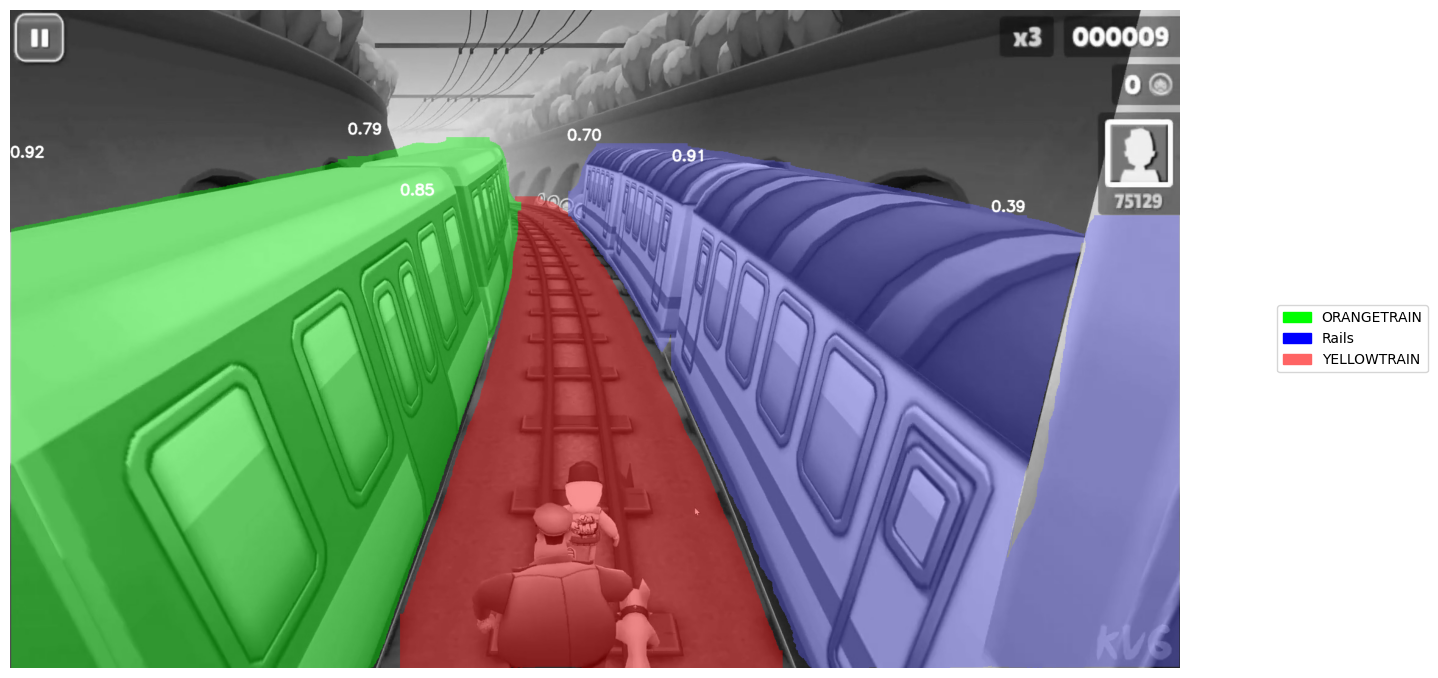


image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0001.jpg: 864x1504 1 ORANGETRAIN, 2 RAMPs, 1 Rails, 282.1ms
Speed: 7.4ms preprocess, 282.1ms inference, 7.8ms postprocess per image at shape (1, 3, 864, 1504)


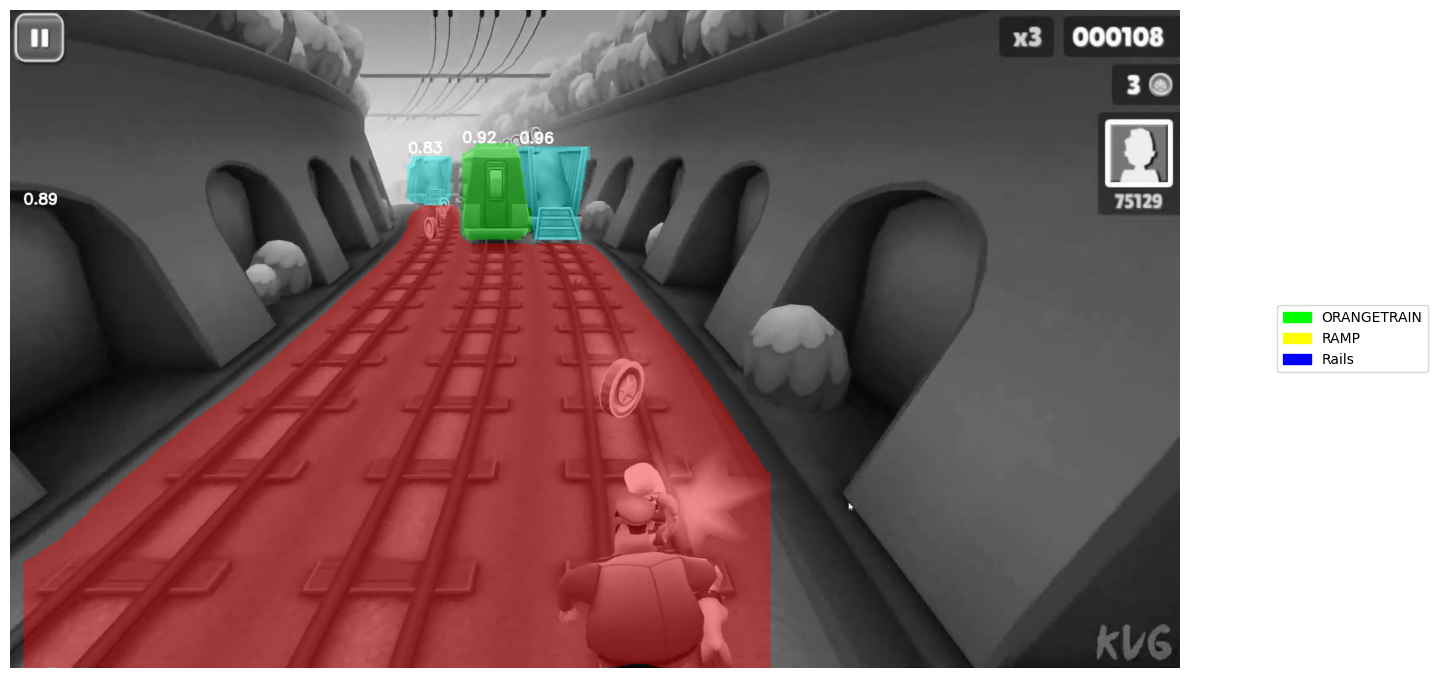


image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0002.jpg: 864x1504 4 GREYTRAINs, 1 HIGHBARRIER1, 2 ORANGETRAINs, 1 RAMP, 2 Railss, 243.6ms
Speed: 7.6ms preprocess, 243.6ms inference, 19.9ms postprocess per image at shape (1, 3, 864, 1504)


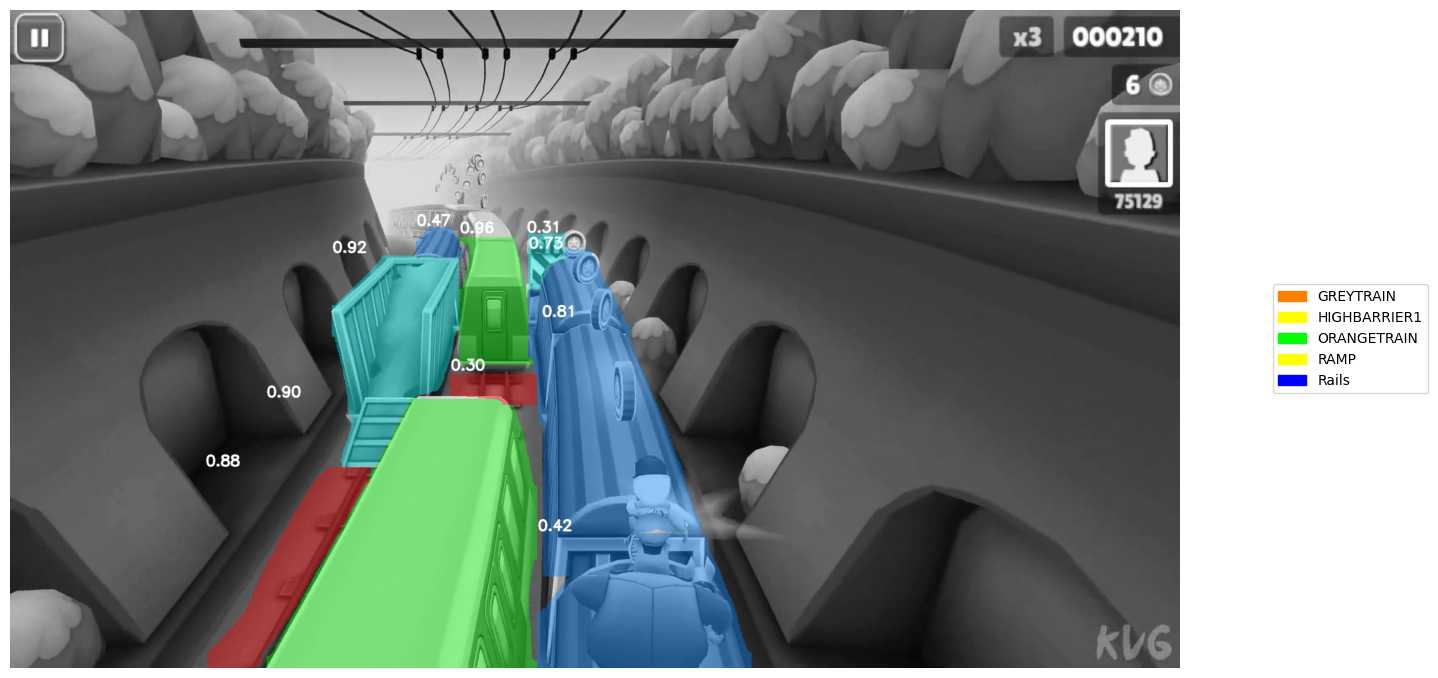

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from ultralytics import YOLO

home    = os.path.expanduser("~")
weights = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"

# ─── 0) MODEL INSTANTIATION & WARM-UP ───────────────────────────────────────────
model = YOLO(weights)
# warm-up on one sample so kernels are JIT-compiled
sample_path = f"{home}/SubwaySurfers/train_screenshots/frame_0200.jpg"
_ = model.predict(source=sample_path, task="segment", conf=0.30, iou=0.45)
# ────────────────────────────────────────────────────────────────────────────────

def cycle(j, i):
    img_path = f"{home}/SubwaySurfers/train_screenshots/frame_00{j}{i}.jpg"
    results  = model.predict(source=img_path, task="segment", conf=0.30, iou=0.45)[0]

    # get masks, classes, boxes & confidences
    polygons    = results.masks.xy
    class_ids   = results.boxes.cls.cpu().numpy().astype(int)
    confidences = results.boxes.conf.cpu().numpy()
    boxes       = results.boxes.xyxy.cpu().numpy().astype(int)
    names       = results.names

    # build gray background
    img_color = cv2.imread(img_path)
    img_gray  = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    bg_gray3  = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

    # assign colors per class
    unique_ids    = sorted(set(class_ids))
    custom_colors = {1:(255,128,0), 6:(0,255,0), 9:(0,0,255), 11:(255,100,100)}
    color_map     = {cid: custom_colors.get(cid,(255,255,0)) for cid in unique_ids}

    # render masks
    overlay = bg_gray3.copy()
    for poly, cid in zip(polygons, class_ids):
        pts = poly.astype(np.int32).reshape(-1,1,2)
        cv2.fillPoly(overlay, [pts], color_map[cid])
    blended = cv2.addWeighted(overlay, 0.4, bg_gray3, 0.6, 0)



#######CONFIDENCE INTERVAL DISPLAY ##################################################
    # draw each confidence just above its mask's bbox
    for conf, box in zip(confidences, boxes):
        x1, y1 = box[0], box[1]
        label  = f"{conf:.2f}"
        cv2.putText(
            blended, label, (int(x1), int(y1)-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA
        )
#################################################################
    # display


    fig, ax = plt.subplots(figsize=(12,8))
    ax.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    ax.axis(False)

    # legend
    patches = [Patch(color=np.array(color_map[cid])/255.0, label=names[cid])
               for cid in unique_ids]
    fig.legend(handles=patches, loc="center right", bbox_to_anchor=(1.2,0.5))
    plt.tight_layout()
    plt.show()


# now this loop will be much faster AND annotate confidences
for i in range(3):
    for j in range(1):
        cycle(j, i)



image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0019.jpg: 864x1504 1 GREYTRAIN, 2 Railss, 4 YELLOWTRAINs, 290.3ms
Speed: 8.2ms preprocess, 290.3ms inference, 11.1ms postprocess per image at shape (1, 3, 864, 1504)


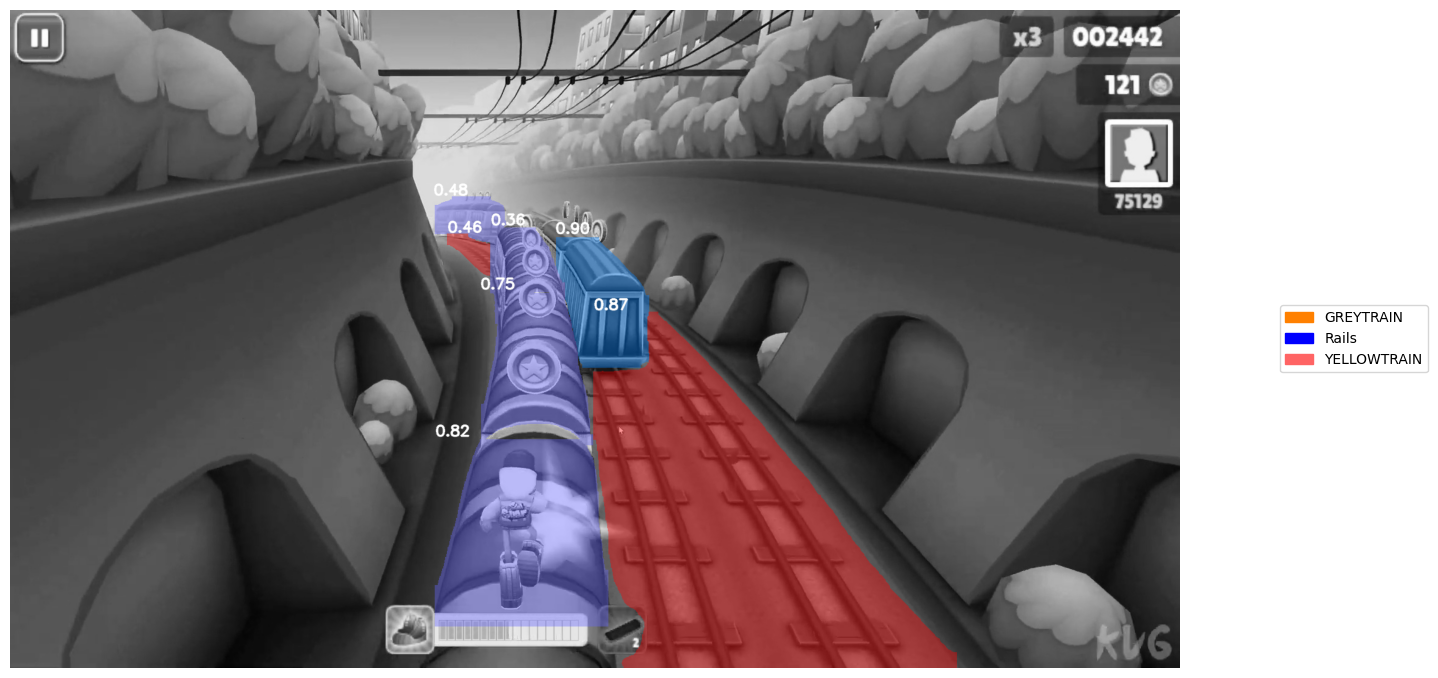

In [14]:
cycle(1,9)